In [1]:
import torch
import os
import random
import utils
import data_utils
import json

import cbm
import plots

In [2]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/cub_cbm_2025_08_12_16_48"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

In [3]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [4]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [5]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 24/24 [00:20<00:00,  1.18it/s]

Accuracy: 73.09%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [6]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:28 - American Crow
Incoming weights:
a bright orange breast [-0.1939] American Crow
a greenish-yellow back [-0.0719] American Crow
a loud caw [0.4472] American Crow
a red belly [0.4046] American Crow
a slimmer body than most crows [0.9267] American Crow
a small, black bird [0.1387] American Crow
a small, dark body [0.0832] American Crow
a small, green body [0.2976] American Crow
a white underbelly [0.0809] American Crow
all black coloration [0.0796] American Crow
blue wings [-0.1081] American Crow
dark wingtips [0.2362] American Crow
fast, erratic flight patterns [-0.0881] American Crow
green plumage [-0.7209] American Crow
grey legs and feet [0.2700] American Crow
large black bird [0.0666] American Crow
mottled grey and white plumage [-0.3409] American Crow
orange or yellow eyes [0.0849] American Crow
orange-yellow legs [-0.2639] American Crow
red and yellow wingtips [-0.3200] American Crow
red shoulders [-0.1477] American Crow
yellow bill [-0.0876] American Crow


In [7]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 40 - Scissor tailed Flycatcher
Highest weights: orange-yellow legs:0.826, black cap and white "eyeline":0.511, a rusty brown color:0.305, a slender, white body:0.290, a purple-red head and breast:0.269, 
Lowest weights: Glossy black wings:-0.763, green wings:-0.556, beak and legs are black:-0.187, a dark brown or black color:-0.182, all black coloration:-0.176, 

Class 17 - Spotted Catbird
Highest weights: green plumage:1.620, green wings:0.448, iridescent blue-green back:0.431, a bright orange breast:0.289, a large, white body:0.263, 
Lowest weights: olive-colored sides:-0.643, yellow wings:-0.280, a brown and white color scheme:-0.121, orange-yellow legs:-0.055, pale gray or white color:-0.037, 



In [8]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:115/115


## Explain model reasoning for random inputs

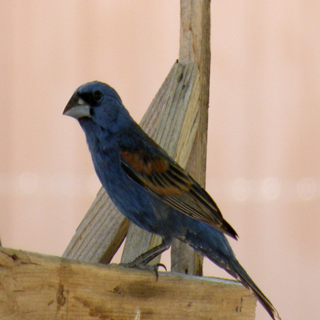

Image:1490 Gt:Blue Grosbeak, 1st Pred:Blue Grosbeak, 6.901, 2nd Pred:Lazuli Bunting, 4.237


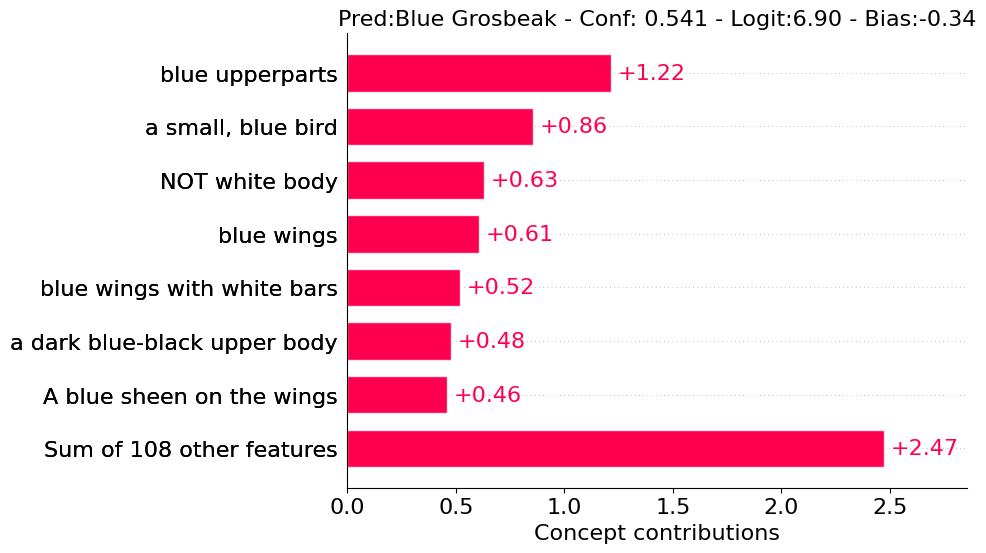

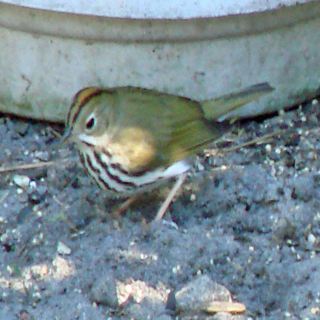

Image:2830 Gt:Ovenbird, 1st Pred:Ovenbird, 7.445, 2nd Pred:White throated Sparrow, 5.145


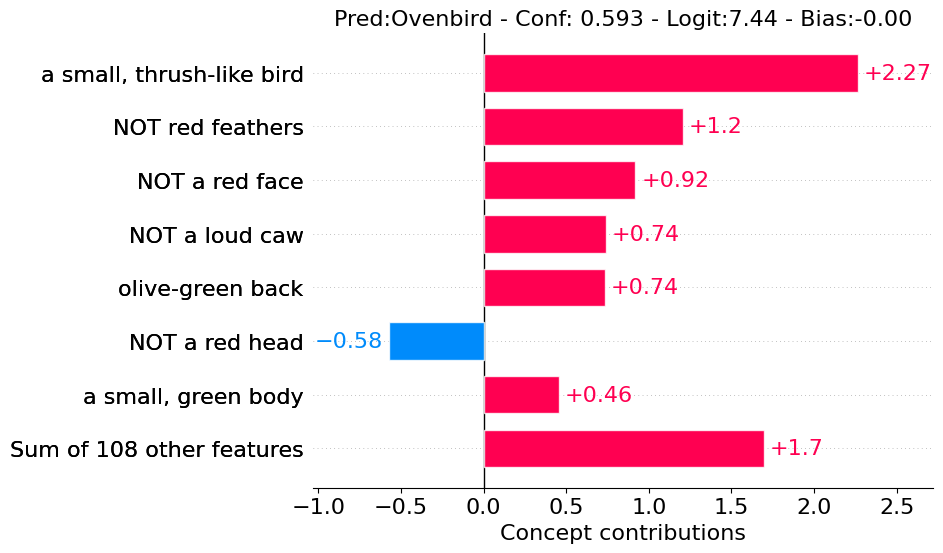

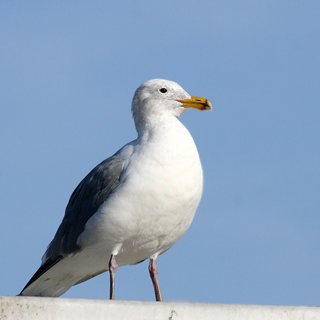

Image:1848 Gt:Western Gull, 1st Pred:Western Gull, 8.320, 2nd Pred:California Gull, 7.121


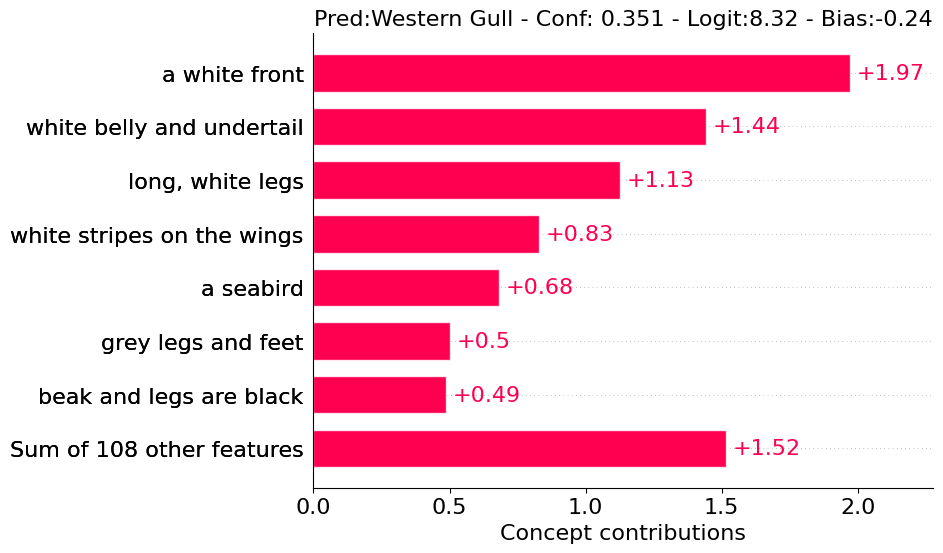

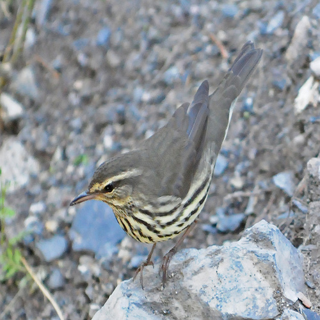

Image:5282 Gt:Northern Waterthrush, 1st Pred:Northern Waterthrush, 7.226, 2nd Pred:Sage Thrasher, 4.447


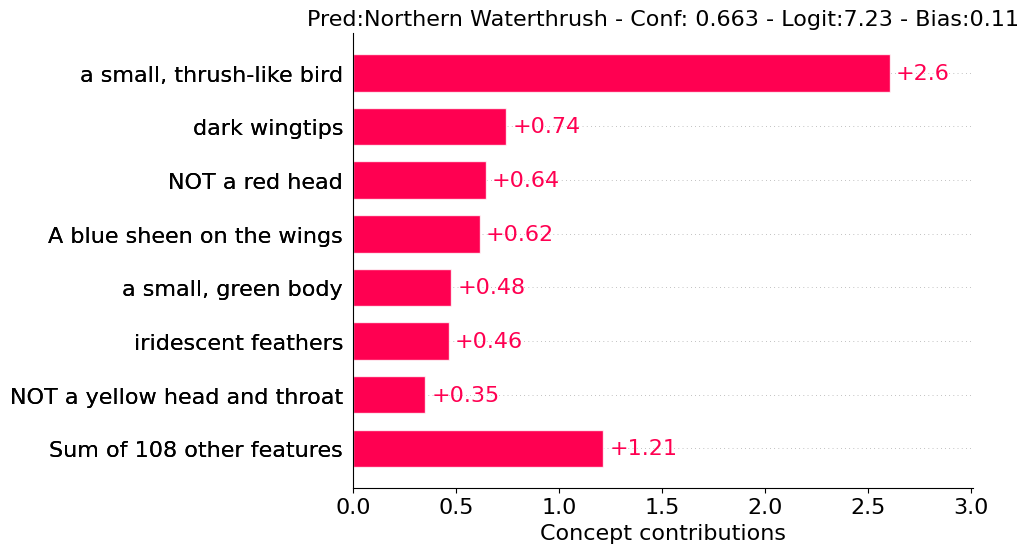

In [9]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)